In [1]:
from keras.models import Model, Sequential
from keras import layers
import numpy as np
from keras.applications import InceptionV3,InceptionResNetV2
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import load_img
from keras import backend as K

import pickle
import h5py

Using TensorFlow backend.


In [2]:
word_embeddings = h5py.File('processed_data/meme_embeddings.hdf5')['meme_embeddings'][:]
with open('processed_data/meme_vocabulary.p', 'rb') as f:
    vocabulary = pickle.load(f)

assert(len(word_embeddings) == len(vocabulary)+1)
VOCAB_SIZE = len(vocabulary)+1

with open('processed_data/inference_meme_embeddings.p', 'rb') as f:
    img_label_embeddings = pickle.load(f)

inv_map = {v: k for k, v in vocabulary.items()}

In [3]:
# Image embedding
img_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(216,216,3), pooling='avg')


In [4]:
# Meme label embedding
def embedding_avg(x):
    return K.mean(x, axis=1)

labels_input = layers.Input(shape=(None,))
glove_embedding = layers.Embedding(VOCAB_SIZE, 300, weights=[word_embeddings], mask_zero=True, input_length=25)
label_embedding = glove_embedding(labels_input)
label_avg_embedding = layers.Lambda(embedding_avg)(label_embedding)

In [5]:
# Embedding model

concat = layers.Concatenate()([img_model.output, label_avg_embedding])
embedding = layers.Dense(300)(concat)
rshp = layers.Reshape((1,300))(embedding)
lstm_layer = layers.LSTM(512, return_sequences=True, return_state=True)
_, lstm_initial_state1, lstm_initial_state2 = lstm_layer(rshp)


seq_input = layers.Input(shape=(None,))
x = glove_embedding(seq_input)
x, _, _ = lstm_layer(x, initial_state=[lstm_initial_state1, lstm_initial_state2])
x = layers.TimeDistributed(layers.Dense(VOCAB_SIZE, activation='softmax'))(x)

embedding_model = Model(inputs=[img_model.input, labels_input, seq_input], outputs=x)

embedding_model.compile('adam', 'categorical_crossentropy')


In [6]:
embedding_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 216, 216, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 107, 107, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 107, 107, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 107, 107, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [7]:
X = h5py.File('processed_data/X.hdf5')
X1 = X['X_img']
X2 = X['X_label']
X3 = X['X_caption']
y = h5py.File('processed_data/y.hdf5')['y']

In [8]:
X1, X2, X3, y

(<HDF5 dataset "X_img": shape (27217, 216, 216, 3), type "<f4">,
 <HDF5 dataset "X_label": shape (27217, 25), type "<i4">,
 <HDF5 dataset "X_caption": shape (27217, 25), type "<i4">,
 <HDF5 dataset "y": shape (27217, 25, 9785), type "|b1">)

In [9]:
embedding_model.fit(x=[X1, X2, X3], y=y, batch_size=70, epochs=50, shuffle='batch')

Epoch 1/50
27217/27217 [==============================] - 629s 23ms/step - loss: 5.8281
Epoch 2/50
27217/27217 [==============================] - 613s 23ms/step - loss: 5.2920
Epoch 3/50
27217/27217 [==============================] - 613s 23ms/step - loss: 4.9833
Epoch 4/50
27217/27217 [==============================] - 613s 23ms/step - loss: 4.6744
Epoch 5/50
27217/27217 [==============================] - 612s 23ms/step - loss: 4.4169
Epoch 6/50
27217/27217 [==============================] - 613s 23ms/step - loss: 4.1940
Epoch 7/50
27217/27217 [==============================] - 616s 23ms/step - loss: 3.9961
Epoch 8/50
27217/27217 [==============================] - 617s 23ms/step - loss: 3.8103
Epoch 9/50
27217/27217 [==============================] - 615s 23ms/step - loss: 3.6388
Epoch 10/50
27217/27217 [==============================] - 615s 23ms/step - loss: 3.4697
Epoch 11/50
27217/27217 [==============================] - 615s 23ms/step - loss: 3.3136
Epoch 12/50
27217/27217 [=====

KeyboardInterrupt: 

In [11]:
embedding_model.save("embedding_meme100_16epochs_2051.h5")

/home/bw/.local/lib/python3.6/site-packages/keras/engine/network.py:877: UserWarning: Layer lstm_1 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_4:0' shape=(?, 512) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


In [16]:
embedding_model.fit(x=[X1, X2, X3], y=y, batch_size=70, epochs=10, shuffle='batch')

Epoch 1/10
27217/27217 [==============================] - 625s 23ms/step - loss: 2.5250
Epoch 2/10
27217/27217 [==============================] - 626s 23ms/step - loss: 2.4179
Epoch 3/10
27217/27217 [==============================] - 621s 23ms/step - loss: 2.3190
Epoch 4/10
27217/27217 [==============================] - 621s 23ms/step - loss: 2.2244
Epoch 5/10
27217/27217 [==============================] - 622s 23ms/step - loss: 2.1357
Epoch 6/10
27217/27217 [==============================] - 621s 23ms/step - loss: 2.0595
Epoch 7/10
27217/27217 [==============================] - 621s 23ms/step - loss: 1.9891
Epoch 8/10
27217/27217 [==============================] - 622s 23ms/step - loss: 1.9092
Epoch 9/10
27217/27217 [==============================] - 622s 23ms/step - loss: 1.8374
Epoch 10/10
27217/27217 [==============================] - 622s 23ms/step - loss: 1.7704


In [18]:
embedding_model.save("embedding_meme100_26epochs_2051.h5")

In [29]:
embedding_model.fit(x=[X1, X2, X3], y=y, batch_size=70, epochs=9, shuffle='batch')

Epoch 1/9
27217/27217 [==============================] - 627s 23ms/step - loss: 1.6093
Epoch 2/9
27217/27217 [==============================] - 632s 23ms/step - loss: 1.5456
Epoch 3/9
27217/27217 [==============================] - 627s 23ms/step - loss: 1.4950
Epoch 4/9
27217/27217 [==============================] - 620s 23ms/step - loss: 1.4477
Epoch 5/9
 2730/27217 [==>...........................] - ETA: 9:11 - loss: 1.3171

KeyboardInterrupt: 

In [30]:
embedding_model.save("embedding_meme100_30epochs_2051.h5")

In [31]:
embedding_model.fit(x=[X1, X2, X3], y=y, batch_size=70, epochs=70, shuffle='batch')

Epoch 1/70
27217/27217 [==============================] - 617s 23ms/step - loss: 1.4029
Epoch 2/70
27217/27217 [==============================] - 619s 23ms/step - loss: 1.3623
Epoch 3/70
27217/27217 [==============================] - 613s 23ms/step - loss: 1.3230
Epoch 4/70
27217/27217 [==============================] - 618s 23ms/step - loss: 1.2888
Epoch 5/70
27217/27217 [==============================] - 612s 22ms/step - loss: 1.2584
Epoch 6/70
27217/27217 [==============================] - 618s 23ms/step - loss: 1.2276
Epoch 7/70
27217/27217 [==============================] - 612s 22ms/step - loss: 1.2014
Epoch 8/70
27217/27217 [==============================] - 617s 23ms/step - loss: 1.1764
Epoch 9/70
27217/27217 [==============================] - 612s 22ms/step - loss: 1.1501
Epoch 10/70
27217/27217 [==============================] - 618s 23ms/step - loss: 1.1279
Epoch 11/70
27217/27217 [==============================] - 612s 22ms/step - loss: 1.1086
Epoch 12/70
27217/27217 [=====

KeyboardInterrupt: 

In [32]:
embedding_model.save("embedding_meme100_73epochs_2051.h5")

In [34]:
embedding_model.fit(x=[X1, X2, X3], y=y, batch_size=70, epochs=27, shuffle='batch')

Epoch 1/27
27217/27217 [==============================] - 618s 23ms/step - loss: 0.8969
Epoch 2/27
27217/27217 [==============================] - 617s 23ms/step - loss: 0.8923
Epoch 3/27
27217/27217 [==============================] - 616s 23ms/step - loss: 0.8914
Epoch 4/27
27217/27217 [==============================] - 617s 23ms/step - loss: 0.8894
Epoch 5/27
27217/27217 [==============================] - 617s 23ms/step - loss: 0.8894
Epoch 6/27
27217/27217 [==============================] - 618s 23ms/step - loss: 0.8875
Epoch 7/27
27217/27217 [==============================] - 617s 23ms/step - loss: 0.8884
Epoch 8/27
27217/27217 [==============================] - 617s 23ms/step - loss: 0.8886
Epoch 9/27
27217/27217 [==============================] - 617s 23ms/step - loss: 0.8886
Epoch 10/27
27217/27217 [==============================] - 618s 23ms/step - loss: 0.8849
Epoch 11/27
27217/27217 [==============================] - 619s 23ms/step - loss: 0.8838
Epoch 12/27
27217/27217 [=====

In [35]:
embedding_model.save("embedding_meme100_100epochs_2051.h5")

In [36]:
embedding_model.fit(x=[X1, X2, X3], y=y, batch_size=70, epochs=30, shuffle='batch')

Epoch 1/30
27217/27217 [==============================] - 616s 23ms/step - loss: 0.8771
Epoch 2/30
27217/27217 [==============================] - 617s 23ms/step - loss: 0.8752
Epoch 3/30
27217/27217 [==============================] - 617s 23ms/step - loss: 0.8734
Epoch 4/30
27217/27217 [==============================] - 616s 23ms/step - loss: 0.8724
Epoch 5/30
27217/27217 [==============================] - 617s 23ms/step - loss: 0.8729
Epoch 6/30
27217/27217 [==============================] - 617s 23ms/step - loss: 0.8733
Epoch 7/30
27217/27217 [==============================] - 616s 23ms/step - loss: 0.8718
Epoch 8/30
27217/27217 [==============================] - 617s 23ms/step - loss: 0.8715
Epoch 9/30
27217/27217 [==============================] - 617s 23ms/step - loss: 0.8718
Epoch 10/30
27217/27217 [==============================] - 617s 23ms/step - loss: 0.8718
Epoch 11/30
27217/27217 [==============================] - 618s 23ms/step - loss: 0.8710
Epoch 12/30
27217/27217 [=====

In [37]:
embedding_model.save("embedding_meme100_130epochs_2051.h5")

In [38]:
embedding_model.fit(x=[X1, X2, X3], y=y, batch_size=70, epochs=30, shuffle='batch')

Epoch 1/30
27217/27217 [==============================] - 616s 23ms/step - loss: 0.8628
Epoch 2/30
27217/27217 [==============================] - 616s 23ms/step - loss: 0.8642
Epoch 3/30
27217/27217 [==============================] - 617s 23ms/step - loss: 0.8621
Epoch 4/30
27217/27217 [==============================] - 617s 23ms/step - loss: 0.8636
Epoch 5/30
27217/27217 [==============================] - 617s 23ms/step - loss: 0.8642
Epoch 6/30
27217/27217 [==============================] - 618s 23ms/step - loss: 0.8633
Epoch 7/30
27217/27217 [==============================] - 617s 23ms/step - loss: 0.8638
Epoch 8/30
27217/27217 [==============================] - 617s 23ms/step - loss: 0.8641
Epoch 9/30
27217/27217 [==============================] - 617s 23ms/step - loss: 0.8664
Epoch 10/30
27217/27217 [==============================] - 618s 23ms/step - loss: 0.8682
Epoch 11/30
27217/27217 [==============================] - 618s 23ms/step - loss: 0.8667
Epoch 12/30
27217/27217 [=====

In [39]:
embedding_model.save("embedding_meme100_160epochs_2051.h5")

In [40]:
embedding_model.fit(x=[X1, X2, X3], y=y, batch_size=70, epochs=30, shuffle='batch')

Epoch 1/30
27217/27217 [==============================] - 615s 23ms/step - loss: 0.8594
Epoch 2/30
27217/27217 [==============================] - 616s 23ms/step - loss: 0.8636
Epoch 3/30
27217/27217 [==============================] - 616s 23ms/step - loss: 0.8687
Epoch 4/30
27217/27217 [==============================] - 619s 23ms/step - loss: 0.8688
Epoch 5/30
27217/27217 [==============================] - 618s 23ms/step - loss: 0.8618
Epoch 6/30
   70/27217 [..............................] - ETA: 10:23 - loss: 0.9221

KeyboardInterrupt: 

In [41]:
embedding_model.save("embedding_meme100_165epochs_2051.h5")

In [23]:
BOUND = 1000

In [25]:
embedding_model.fit(x=[X1[:BOUND], X2[:BOUND], X3[:BOUND]], y=y[:BOUND], batch_size=70, epochs=2, shuffle='batch')

Epoch 1/2
1000/1000 [==============================] - 8s 8ms/step - loss: 1.0925
Epoch 2/2
1000/1000 [==============================] - 8s 8ms/step - loss: 0.9926


# Inference

In [12]:
from PIL import Image
from pathlib import Path
import os

In [13]:
from keras.preprocessing.sequence import pad_sequences

def generate_captions(model, image_embedding, label_embedding, beam_size=5):
    start = [vocabulary['<start>']]
    captions = [[start,0.0]]
    step = 0
    temp = 1.3
    while(len(captions[0][0]) < 25):
        temp_captions = []
        for caption in captions:
            partial_caption = pad_sequences([caption[0]], maxlen=25, padding='post')
            next_words_pred = model.predict([image_embedding, label_embedding, np.asarray(partial_caption)])[0,step]
            next_words = np.argsort(next_words_pred)[-beam_size:]
            candidate_next_words = next_words_pred[next_words]
            candidate_next_words = (candidate_next_words**(1/temp))/(candidate_next_words**(1/temp)).sum()
            word = np.random.choice(next_words, p=candidate_next_words)
            new_partial_caption, new_partial_caption_prob = caption[0][:], caption[1]
            new_partial_caption.append(word)
#             new_partial_caption_prob += next_words_pred[word]
            temp_captions.append([new_partial_caption,new_partial_caption_prob])
        captions = temp_captions
#         captions.sort(key = lambda l:l[1])
#         captions = captions[-beam_size:]
        step +=1
    return captions

def sentences(caption_idxes):
    words = []
    for idx in caption_idxes[0]:
        if idx != 0:
            word = inv_map[idx]
            if word == '<start>':
                continue
            if word == '<end>':
                break
            else:
                words.append(word)
    print(' '.join(words))

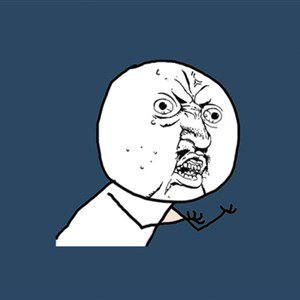

i should buy <sep> a <unk>
<sep> i should buy a helicopter
i should buy an <unk> <sep> it ! it's just a good meme
what if everyone is talking to <unk> <sep> and we landed on sucking and a - boo ?
so , i says to get a life <sep> and i will play lol ?
i told him our <unk> been murdered <sep> he replied " lol aggro <unk> "
i told him to whisper dirty things in the ear <sep> he said <unk> "
<sep> fuck shit up !
<sep> i should build a snow
<sep> i should buy a hatchet


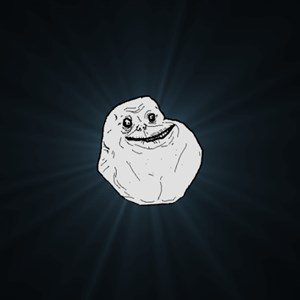

<sep> <unk>
<unk> <sep> why ??? ?
i told him i wanted a divorce <sep> he asked if she was fat " and you are the knee "
so your telling me <sep> people get free to work on the internet
<sep>
<sep> i should buy a <unk>
<sep> <unk>
so i says to do something with you <sep> and i just met you and not
i told him i wanted a divorce <sep> he said , " <unk> tears "
what if i told you that <sep> that you can use a meme with a joke ?


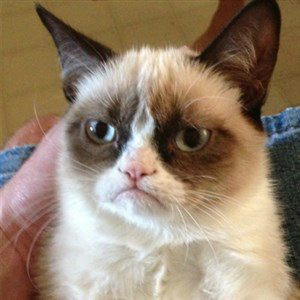

i should buy <sep> starcraft 2
i told him our baby is turning <sep> he wanted me raped him
what if i told you that you could be gay <unk> <sep> and you are allowed to be a taxi driver or a stupid
<unk> are like <sep> mechanics for your body
so you want me to get along <sep> cuz you're gonna have a bad time
<unk> , zorra <sep>
<sep> i should learn to <unk>
<sep> fuck shit up !
i told him i was raped by three <sep> but that's not we really have
i should make a band <unk> <sep>


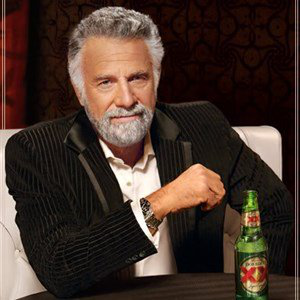

<sep>
i should buy a tablet <sep>
what if i told you <sep> you don't need to type www
i should <sep> get more staff
<unk> <sep> no one
what if the mayans predicted acta <sep> the government is only real women ?
<sep> i should buy a helicopter
so you're telling me , you could donate a phone <sep> your <unk> got that shit in your facebook ?
i told him our son beats their <unk> gear his ship <sep> he said " lol lag '' still a <unk>
so you're a christian who can't spell <sep>


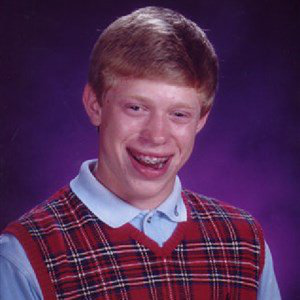

what if the mayans predicted acta <sep> because we had a free to win hide - laws of our cats
so you're telling me <sep> you <unk> get pregnant ?
<sep> <unk>
<sep> i should make a bow
so you're telling me that you can eat <sep> but you eat too much to eat food ?
what do you mean <sep> donald trump is leading ??
what if i told you <sep> you don't need to be a political argument
so your telling me <sep> that the boot to the gym to run out for the first time
i should buy a tablet <sep>
<sep>


In [17]:
# after 17 epochs
p = Path('memes')
meme_files = list(p.glob('*.txt'))
meme_files.sort(key=os.path.getmtime)
meme_files = list(map(lambda x: x.stem, meme_files))[:5]


for i, meme in enumerate(meme_files):
    X_test_img = img_label_embeddings[meme][0]
    X_test_label = img_label_embeddings[meme][1]
    display(Image.open(f'{p.joinpath(meme)}.png'))
    
    for _ in range(10):
        captions = generate_captions(embedding_model, X_test_img, X_test_label)
        sentences(captions[0])

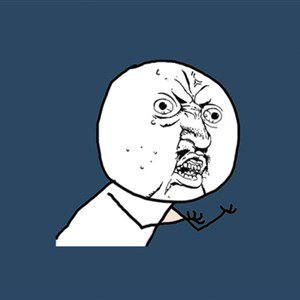

i don't always use internet explorer instead of me <sep> but i dont do shit
i should make a <unk> <sep>
you don't like the right ? <sep>
i don't understand <sep> minecraft
you are poor ? <sep> why you no understand ?
so you're telling me <sep> people in your country pay to save money ?
you mean to tell me <sep> you don't eat that dance
so you're telling me that <sep> your country has more money than you ?
so you tellin me <sep> you get so much to eat meat ?
<sep> i should move on this long time im moving to move on my wall


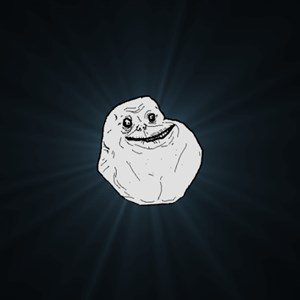

so your telling me <sep> you can be a feminist
<sep> i should start a <unk> channel
you are giving a <unk> and a happy - eating pussy <sep> but thats none of my business
<sep> " mayo "
so you are telling me <sep> people use the world to be more attracted to us ? to ?
so you're tellin me that <sep> nigeria plays basketball ??
i dont always drink milk <sep> but when i do .
<unk> <sep> y u no have quicksave ?
i just want to <sep> fuck off
so your telling me <sep> that you eat too much food ?


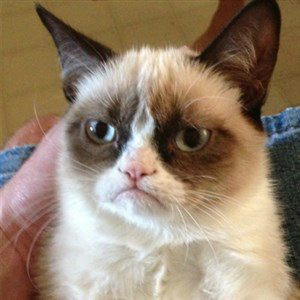

so you're telling me that in america , poor ? <sep> should i just get famous on memegenerator . net ?
i dont always make millions of memes . <sep> but when i do ... i use the sign
i should buy <sep> a human
i don't always have time , but i don't give you , <sep> but when i do i make sure it's only a few
you said i would be completed in the game <sep> <unk> ..... i don't
so you mean to tell me <sep> people drive to pay for free to pay for food ? <sep> because you're not
i dont always make memes <sep> but when i do , it's with me for this
<unk> <sep> why can't you ? ? ?
you said you <unk> on the internet <sep> the lie detector determined that was a lie
<sep> " <unk> "


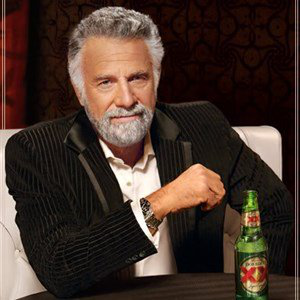

you don't want bum sex ? <sep> because thats how you get a boyfriend <unk> ... sorry .
<unk> <sep>
<sep>
<sep>
<unk> are like <sep> the native americans of the middle east coast
<unk> is <sep> no more better than this
i just got <sep> fucked up !
<sep> i should get a haircut
<unk> <sep>
so you're telling me <sep> you <unk> to eat away


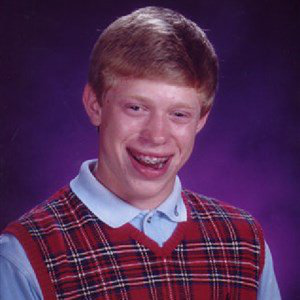

you mean to say <sep> you say they <unk> in the kitchen ?
so you're telling me that you came here <sep> i can eat a bowl of water ?
i don't always have sex <sep> but when i do , its because angels deserve better
so you're telling me <sep> you have so much clean water , that you can shit in it ?
you said you didn't study for the finals <sep> but thats none of my business
so you telling me you have <unk> <sep> because you didn't want free condoms ?
i dont always use bing <sep> but when i do , i use my search history
if you're happy and you have too many electrons <sep> you're gonna have pad thai
i should buy a <unk> <sep>
<sep> <unk> directioners ... it's the holiday !!


In [20]:
# after 26 epochs
p = Path('memes')
meme_files = list(p.glob('*.txt'))
meme_files.sort(key=os.path.getmtime)
meme_files = list(map(lambda x: x.stem, meme_files))[:5]


for i, meme in enumerate(meme_files):
    X_test_img = img_label_embeddings[meme][0]
    X_test_label = img_label_embeddings[meme][1]
    display(Image.open(f'{p.joinpath(meme)}.png'))
    
    for _ in range(10):
        captions = generate_captions(embedding_model, X_test_img, X_test_label)
        sentences(captions[0])

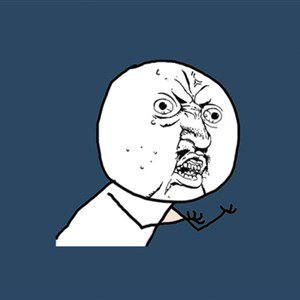

i don't always get beaten by the wrong ones i do <sep> but when i do , i ask .
<sep> i should get a masters degree
i don't always use bing <sep> but when i do , i'm usually to be in <unk>
what doesn't kill you <sep> failed
i don't usually fart <sep> but when i do , i lean like this
i don't always make meme <sep> bottom text
i don't always have a crush on your <sep> . . . but when i'm a good morning
<sep> " nurse "
i don't always have a girlfriend <sep> but when i do , it's with my wife
i don't always use internet explorer <sep> that when i do , it is it <unk> spoil its good


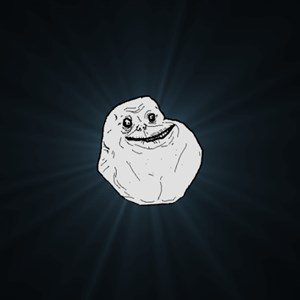

i don't always get a boner <sep> but when i do it's because the only one to find one
i don't always make memes <sep> but when i do , i use the wrong ones
<unk> <sep> y u no grow on trees ?
i dont always make memes <sep> but when i do , i generate it on the table
i dont usually go to bed <sep> it's about to shit i out
i love my birthday candles <sep> but im already stoned
i don't usually go to the <sep> no one , one
<unk> valentines day ? <sep> ok ...
so you're telling me israel provided gaza strip with concrete and tools to rebuild it <sep> if you know what i bean
so you're saying <sep> i don't care if i dont know you <unk>


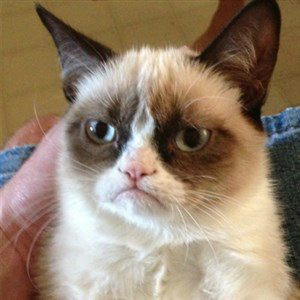

<sep> y u no let me finish this meme generator ?
i don't always make a meme <sep> but when i do , i generate them twice
so you're telling me <sep> that vegetarians buy fake facebook games on a <unk> but still a day in the head ?
<unk> <sep> y u no take away homework
i don't always use yahoo <sep> to search google when i'm a meme in my meme generator
so you're telling me israel provided gaza strip with concrete and tools to rebuild your own <sep> if you had it right for your
i don't always masturbate in public , right ? <sep> i don't always get the good at my way .
i don't always make memes <sep> but when i do , it's only one to be good
i don't always use yahoo <sep> but when i do , it's to search for google
i have lots of money to eat <sep> that's a salt


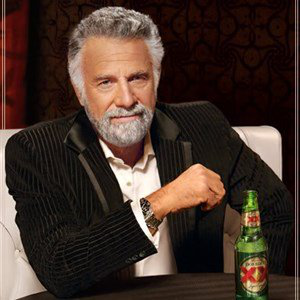

i dont always have alzheimers <sep> i don't always have alzheimers
what do i have to do homework ? <sep> because that's how you get alcohol poisoning
i had fun once <sep> and the deputy
so you're telling me that you are <sep> people actually take your food and not food out ?
i love romeo and juliet <sep> they both
i don't always have sex <sep> but when i do , it's because when i do it's because it's six
i don't always make a meme at meme generator <sep> but when i do , i manage to the top text
<unk> day <sep> they have time
what if i told you , i dont always <unk> jokes <sep> but when i do , it's with me
i dont always text back <sep> but when i do , i say yes to me it , i just want <unk>


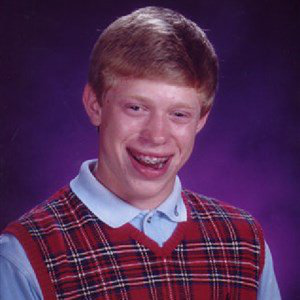

so you're telling me <sep> that i can see a photo of my dog ?
i don't always use the wrong meme <sep> but when i do , i use the internet <unk>
i dont always make a youtube <sep> but when i do , i search for a meme generator
<unk> day is <sep> i don't give you up
what do i call the <unk> ? <sep>
i love titanic ! my favourite character was the iceberg <sep> i grew the mouse '
i dont always make memes <sep> but when i do , they usually spit it up
i dont always make memes <sep> but i don't always get up as many people
<unk> <sep> y u always right there ?
<sep> i should buy a <unk>


In [26]:
# try with over fitting
p = Path('memes')
meme_files = list(p.glob('*.txt'))
meme_files.sort(key=os.path.getmtime)
meme_files = list(map(lambda x: x.stem, meme_files))[:5]


for i, meme in enumerate(meme_files):
    X_test_img = img_label_embeddings[meme][0]
    X_test_label = img_label_embeddings[meme][1]
    display(Image.open(f'{p.joinpath(meme)}.png'))
    
    for _ in range(10):
        captions = generate_captions(embedding_model, X_test_img, X_test_label)
        sentences(captions[0])

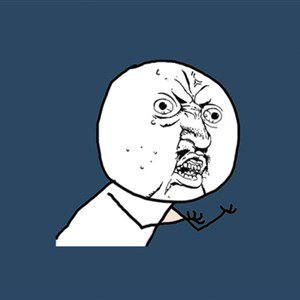

i don't always launch internet explorer ! <sep> but i'm too lazy to lose
i have a <unk> <sep>
what did you say <sep> what ?!
what if oxygen is really hot <sep> and you didn't see it around it are ?
so you telling me <sep> you have a <unk> and where you get into 3rd world country ?
what ? <sep> did you have a big ass
so your telling me that you can save 15 % but not food ? <sep> when you can't remember the first windows 6
so you're telling me <sep> the pope can resign ?
so you're telling me <sep> people actually think of ugandan children ?
i dont usually make up <sep> but when i do , i use it as the last time i get to work at work


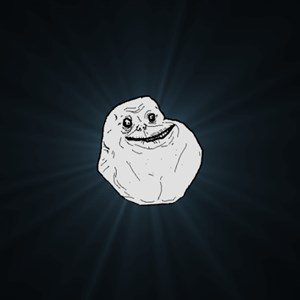

so you're telling me that <sep> you don't need to eat food on it
<unk> is like <sep> snickers
what if i told you <sep> you can have to take the <unk> without my glasses
so your telling me <sep> you want to adopt a <unk>
so your telling me that i can see a couple and share post on memegenerator <sep> but they have to keep their own memes
i just ate a . <sep> now i have a <unk> .
i should get a portrait of myself in <sep> i'll get a cold
what if <unk> are a man <sep> when u say triangle between a rainbow underwater called a <unk>
what if i told you <sep> you don't need a prize for at a school bus
i don't always use the bathroom in public toilet <sep> but when i do i use to shower


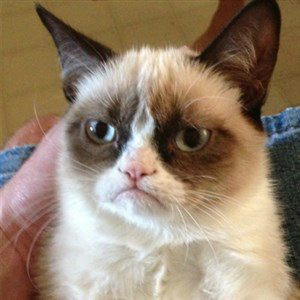

i have a larger bladder than my hands <sep> but that's none of my business
what if i told you <sep> there is no standard way you have to be my <unk>
i don't always get a boner on this <sep> but when i do i lean this too many bottles
<unk> ? <sep> you not lego in the room .
you mean to tell me <sep> i can't use a different words on purpose ?
i dont usually go out for me to <sep> i <unk> a great on fire ;
<unk> , chi chi and 18 ? <sep> better drink my own planet
so your telling me ... <sep> people get money for money
i just wanted to say the alphabet <sep> so i became the successful
i don't always launch internet explorer <sep> but when i do i have to use <unk> points


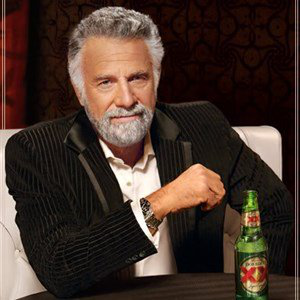

i just got fired from discovery <sep> better drink my own pee
so you're telling me <sep> your dog has a therapist
i don't always use lube when <sep> but you can help , but it's time with me
i don't always get a boner in but when i do <sep> i do the only thing to do .
so , you mean to <unk> me <sep> i don't get a new school ?
so you can play guitar hero for a test ? <sep> you can play mario ?
so you mean to tell me <sep> you can eat a meal with a lion ?
i have to go to work <sep> to tell them to go to hell
i don't understand <sep> i don't always have time
i should buy <sep> an <unk>


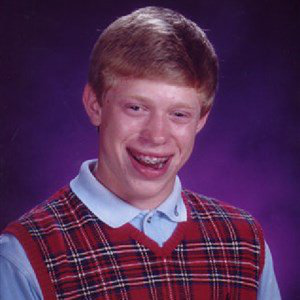

<unk> ? <sep> you are not a better !
so you're telling me <sep> you can eat a whole jar of water so much water is like hot
what if the dogs are in the car <sep> and it was better a car ?
what if i told you <sep> you can be every time on the internet with your body
<unk> <sep>
so you're telling me <sep> people just throw rice in a truck so i can eat food ?
what if i told you <sep> that the blue pill was a roofie
what if we had a <unk> in the sims but just just <sep> see ourselves in your room .
<unk> <sep> please buy me sushi
what if the world is a good actor <sep> and it's funny , if you can't get it


In [28]:
# after 26 epochs
p = Path('memes')
meme_files = list(p.glob('*.txt'))
meme_files.sort(key=os.path.getmtime)
meme_files = list(map(lambda x: x.stem, meme_files))[:5]


for i, meme in enumerate(meme_files):
    X_test_img = img_label_embeddings[meme][0]
    X_test_label = img_label_embeddings[meme][1]
    display(Image.open(f'{p.joinpath(meme)}.png'))
    
    for _ in range(10):
        captions = generate_captions(embedding_model, X_test_img, X_test_label)
        sentences(captions[0])

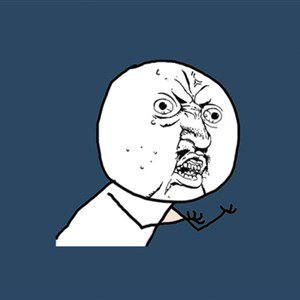

i told a joke to make a soul <sep> now god this <unk>
i don't always get a boner in class <sep> but when i do , it's right
<sep> be danna
i don't always drink beer <sep> so i do i'm cry
so you're telling me <sep> people in america pay water just to pay our money to charity ?
i don't always use the right meme <sep> but when i do , i don't
so you mean to tell me <sep> that there's a surprise for those who wear white in <unk> tomorrow ?
brace yourselves <sep> the ' forever alone ' valentines day posts are coming
so you're telling me <sep> <unk> going to make sense tonight ?
brace yourselves <sep> the enriched ' is a ' brace '


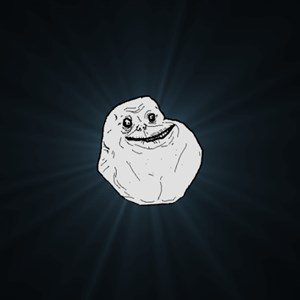

<sep> love one direction
i should buy some boots <sep> and i have the poops i did
so you are telling me miley cyrus is alive <sep> and he is going to president of his followers than that ?
what if i told you <sep> that not every woman who friend requests you wants you
i don't always drink beer <sep> because its because i'm not <unk>
i dont always drink milk , but when the other kid in the house <sep> but that none is my business
i don't always talk to arts students <sep> but when i do , i ask for large fries
<sep> fuck you
i dont flush the toilet <sep> i pull the shit out of it
i told him i was leaving from now <sep> he said thats not that real sister ''


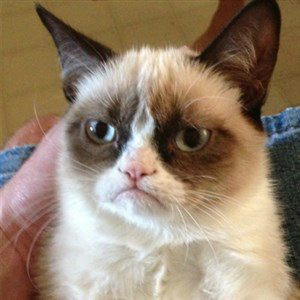

i don't need legs <sep> to kick your ass
i don't always use the correct character <sep> but when i do , i drink my own piss
brace yourselves <sep> the ' brace yourselves ' jokes are coming
so your saying <sep> an appetizer is before a meal ? and dessert is after a meal
i should <sep> drink beer
i told him we need some goods from the market <sep> he said " relax i choose a support "
brace yourself <sep> the people who say i never said brace yourself are coming
i don't know who <sep>
i just got mw3 and skyrim <sep> and i dont know which one to play
what did the blind paraplegic get for chrismas ? <sep> cancer


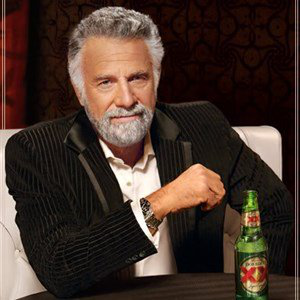

<sep>
<sep> be sexy
what did one orphan say to the ice bucket challenge in the stream <sep> can't they cant have their <unk> ?
<sep>
i dont always make memes <sep> but when i do i
so you're telling me that <sep> pop , country , hip - hop , trap and rap is considered good ?
what do you call a man without arms or legs ? <sep> by his first or last name , depending on how close you
so you're telling me <sep> that i can eat that i <unk> ?
i told him i wanted divorce <sep> he said " qq more "
what did the five fingers say to the face , old chum ? <sep> kapow !!!


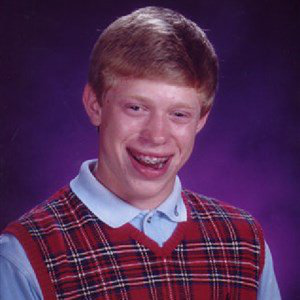

i don't always talk to arts students <sep> but when i do , i ask for a venti
so your telling me <sep> i am two of your country you can understand ?
i should <sep> get more staff
<sep> fuck satan to death !
what do you call a black guy who graduated medical school ? <sep> a doctor
<sep>
what if the government invented to sit there is no one bats an eye <sep> one plane goes in 2012 and everyone loses their
i don't always use memes <sep> but when i do i use the wrong one
<sep> love one direction
brace yourselves <sep> " may i do something <unk> try to do something about gun


In [33]:
# after 73 epochs
p = Path('memes')
meme_files = list(p.glob('*.txt'))
meme_files.sort(key=os.path.getmtime)
meme_files = list(map(lambda x: x.stem, meme_files))[:5]


for i, meme in enumerate(meme_files):
    X_test_img = img_label_embeddings[meme][0]
    X_test_label = img_label_embeddings[meme][1]
    display(Image.open(f'{p.joinpath(meme)}.png'))
    
    for _ in range(10):
        captions = generate_captions(embedding_model, X_test_img, X_test_label)
        sentences(captions[0])

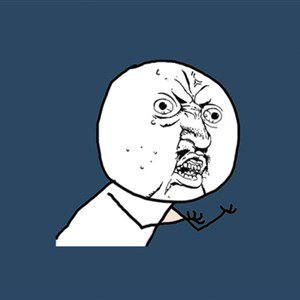

i don't think it's nice you laughin ' <sep> you see , my tie don't like people laughin '
so you're telling me <sep> <unk> is getting a kfc ?
what if i told you <sep> i don't care about the ice bucket challenge
i don't always drink pee <sep> but when i do , it's dos equis
what is a cation afraid of ? <sep> a <unk>
so i says to the copper i says : <sep> in response you are !
<unk> <sep>
what if i told you <sep> you can make your own meme
i should <sep> get more staff
i should build <sep> a basement vault


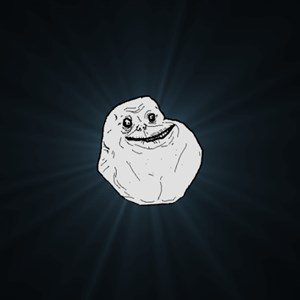

<unk> <sep>
i dont usually cry over <unk> milk <sep> but this time it was chocolate
i don't think aliens are here <sep> i know aliens are here !
i dont usually turn up the volume on my pokemon game <sep> but when i do , its to hear
what if i told you <sep> you don't get to the <unk> , that i dont always talk
i don't always drink beer but <sep> when i do ... i eat dos equis
<sep> get ball space
i don't always drink pee <sep> but when i do , it's dos equis
<sep> fuck off
i don't think aliens are here <sep> i know aliens are here !


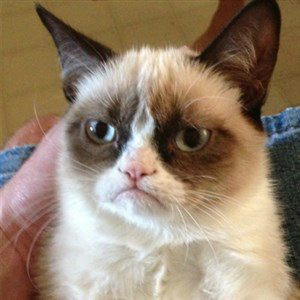

i don't want to be <unk> , but when i do ... <sep> i prefer to be a bad person .
what is this life you speak of ? <sep> and where can i download one ?
so you are telling me ? <sep> that you want me to come over . i mean to do that in my house to
so you're telling me <sep> i get a free burger if i fill out a survey
so you're telling me <sep> i get a <unk> personality ?
i should buy a flashlight <sep>
<unk> <sep> y u no cut my hair off ?
<sep> fuck off
<unk> , ya im gonna need you <sep> to work on caturday
i need that ten foot tree <sep> double flocked with bacon !


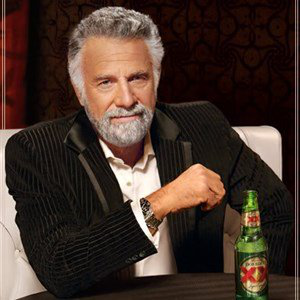

so you're telling me <sep> you have so much clean water , you shit in it ?
what if i told you <sep> there is no corporate salvation
what the fuck does a puffin has to do <sep> with unpopular opinions ?!
<sep> i <unk> have bought that boat
i dont always drink water but <sep> but it is always fat
what if i told you <sep> that you didn't have to dump ice on your head to donate to charity
i should buy a boat <sep> and rape children on it
i dont always finish my jokes <sep> but when i do
i don't always drink beer <sep> but when i do , its because this great
i don't always get called a racist <sep> but when i do , it's when i'm winning a political argument


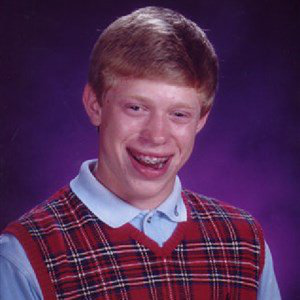

i don't always use internet explorer <sep> but when i do , it's usually to download a better browser
<sep> i should make a bow
i told him to tell me he loved me <sep> he does not accept my next night
what if i told you <sep> i don't care about the baby
<unk> <sep> no te pases de verga
<sep> <unk> yo life
<unk> <sep> no te pases de verga
<unk> <sep>
<sep> get fucked up !
so you are telling me <sep> people drive to the gym ?


In [42]:
# after 165 epochs
p = Path('memes')
meme_files = list(p.glob('*.txt'))
meme_files.sort(key=os.path.getmtime)
meme_files = list(map(lambda x: x.stem, meme_files))[:5]


for i, meme in enumerate(meme_files):
    X_test_img = img_label_embeddings[meme][0]
    X_test_label = img_label_embeddings[meme][1]
    display(Image.open(f'{p.joinpath(meme)}.png'))
    
    for _ in range(10):
        captions = generate_captions(embedding_model, X_test_img, X_test_label)
        sentences(captions[0])